In [1]:
# %% 1
# Package imports
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import sklearn.datasets
import sklearn.linear_model
import matplotlib
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from pprint import pprint
import copy

categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']

newsgroups_train = fetch_20newsgroups(subset='train',  categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test',  categories=categories)

# pprint(newsgroups_train.data[0])

num_train = len(newsgroups_train.data)
num_test  = len(newsgroups_test.data)

vectorizer = TfidfVectorizer(max_features=512)

X = vectorizer.fit_transform( newsgroups_train.data + newsgroups_test.data )
X_train = X[0:num_train, :]
X_test = X[num_train:num_train+num_test,:]

Y_train = newsgroups_train.target
Y_test = newsgroups_test.target


print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(2034, 512) (2034,)
(1353, 512) (1353,)


In [2]:
# # Generate a dataset and plot it
# np.random.seed(0)
# X, y = sklearn.datasets.make_moons(1000, noise=0.20)
# print('输入：',X.shape)
# print('输出',y.shape)
# plt.scatter(X[:,0], X[:,1], s=40, c=y, cmap=plt.cm.Spectral)

In [3]:
# # Train the logistic regression classifier
# clf = sklearn.linear_model.LogisticRegressionCV()
# clf.fit(X, y)

In [4]:
# # Helper function to plot a decision boundary.
# # If you don't fully understand this function don't worry, it just generates the contour plot below.
# def plot_decision_boundary(pred_func):
#     # Set min and max values and give it some padding
#     x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
#     y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
#     h = 0.01
#     # Generate a grid of points with distance h between them
#     xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
#     # Predict the function value for the whole gid
#     Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
#     Z = Z.reshape(xx.shape)
#     # Plot the contour and training examples
#     plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
#     plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)

In [5]:
# # Plot the decision boundary
# plot_decision_boundary(lambda x: clf.predict(x))
# plt.title("Logistic Regression")

### drop out

In [6]:
def dropout_Z(Z_out, level):
    if level < 0. or level >= 1:
        #level是概率值，必须在0~1之间
        raise Exception('Dropout level must be in interval [0, 1[.')
    retain_prob = 1. - level
    #我们通过binomial函数，生成与x一样的维数向量。
    #binomial函数就像抛硬币一样，我们可以把每个神经元当做抛硬币一样
    #硬币 正面的概率为p，n表示每个神经元试验的次数
    #因为我们每个神经元只需要抛一次就可以了所以n=1，size参数是我们有多少个硬币。
    #即将生成一个0、1分布的向量，0表示这个神经元被屏蔽，不工作了，也就是dropout了
    sample=np.random.binomial(n=1,p=retain_prob,size=x.shape)
    Z_out *=sample#0、1与x相乘，我们就可以屏蔽某些神经元，让它们的值变为0
    Z_out /= retain_prob
 
    return Z_out

In [7]:
def dropout_single_Z(memo_forward, level):
    if level < 0. or level >= 1:
        #level是概率值，必须在0~1之间
        raise Exception('Dropout level must be in interval [0, 1[.')
    retain_prob = 1. - level
    #我们通过binomial函数，生成与x一样的维数向量。binomial函数就像抛硬币一样，我们可以把每个神经元当做抛硬币一样
    #硬币 正面的概率为p，n表示每个神经元试验的次数
    #因为我们每个神经元只需要抛一次就可以了所以n=1，size参数是我们有多少个硬币。
    sample=np.random.binomial(n=1,p=retain_prob,size= 1)#即将生成一个0、1分布的向量，0表示这个神经元被屏蔽，不工作了，也就是dropout了
    memo_forward['Z_out'] *= sample#0、1与x相乘，我们就可以屏蔽某些神经元，让它们的值变为0
    memo_forward['Z_hide'] *= sample#0、1与x相乘，我们就可以屏蔽某些神经元，让它们的值变为0
    memo_forward['Z_out'] /= retain_prob#0、1与x相乘，我们就可以屏蔽某些神经元，让它们的值变为0
    memo_forward['Z_hide'] /= retain_prob#0、1与x相乘，我们就可以屏蔽某些神经元，让它们的值变为0

    return memo_forward

### batch norm

In [8]:
# def batch(X_train, batch_size):
#     batchs = []
#     np.random.choice(X_train.shape[0], batch_size)
    

初始化层

In [9]:
def init_layer(input_dim, output_dim, actFunc):
    np.random.seed(0)
    W = np.random.randn(input_dim, output_dim) / np.sqrt(input_dim)
    b = np.zeros((1,output_dim))
    print('w:',W.shape)
    print('b:',b.shape)
    layer = {'W': W, 'b': b, 'actFunc': actFunc}
    return layer

In [10]:
def init_layers(nn_architecture):
    layers = []
    for l in nn_architecture:
        layer = init_layer(l['input_dim'], l['output_dim'], l['actFunc'])
        layers.append(layer)
    return layers

激活函数

In [11]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def relu(z):
    return np.maximum(0, z)


softmax

In [12]:
def softmax(Z):
    exp_scores = np.exp(Z)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    return probs

反向传播

In [13]:
def sigmoid_backward(dA, Z):
    sig = sigmoid(Z)
    return dA * sig * (1-sig)

def relu_backward(dA, Z):
    dZ = np.array(dA, copy = True)
    dZ[Z <= 0] = 0
    return dZ

def tanh_backward(dA, Z):
    t = np.tanh(Z)
    res = (1 - t * t)
    return res * dA

损失函数

In [14]:
def loss(Z, y):
    # 计算损失
    probs = softmax(Z)
    corect_logprobs = -np.log(probs[range(num_examples), y])
    data_loss = np.sum(corect_logprobs)
    #在损失上加上正则项（可选）
    # data_loss += reg_lambda/2 * (np.sum(np.square(W1)) + np.sum(np.square(W2)))
    return 1./num_examples * data_loss

前向传播

In [15]:
def single_layer_forward_prop(X, layer):
    W = layer['W']
#     print(W.shape)
    Z = X.dot(layer['W']) + layer['b']
    if layer['actFunc'] is 'relu':
        actFunction = relu
    elif layer['actFunc'] is 'sigmoid':
        actFunction = sigmoid
    else:
        actFunction = np.tanh
    return actFunction(Z), Z

In [16]:
def full_layers_forward_prop(X, layers):
    memory_forward = []
    Z_out = X
    memo_forward = {
        'Z_out': X
    }
    memory_forward.append(memo_forward)
    layers_now = 0
    for layer in layers:
#         print('forward layers_now:',layers_now)
        Z_out, Z_hide = single_layer_forward_prop(Z_out, layer)
        memo_forward = {
            'Z_out': Z_out,
            'Z_hide': Z_hide
        }
        if dropout:
            memo_forward = dropout_single_Z(memo_forward, level)

        memory_forward.append(memo_forward)
        layers_now += 1

    # 返回最终的Z_out => actFunc(Z=X*W + b)
    # memory_forward记录每一层的Z_out=actFunc(Z_hide)和Z_hide=W*X+b
#     print('Z_out: ',Z_out.shape)
    return Z_out, memory_forward

反向传播

In [17]:
def single_layer_backward_prop(memo_forward_now, memo_forward_pre, dA_now, layer):
    # 前向神经元个数
    # dA_now为由下一层传回的梯度
    # memo_forward_pre 记录上一层计算结果， Z_hide=X*w+b和Z_out => X_pre
    # memo_forward_now 记录当前层的计算结果，Z_hide => Z_now和Z_out
    X_pre = memo_forward_pre['Z_out']
    Z_now = memo_forward_now['Z_hide']
    back_dim = X_pre.shape[0]

    if layer['actFunc'] is 'sigmoid':
        actFuncBack = sigmoid_backward
    elif layer['actFunc'] is 'relu':
        actFuncBack = relu_backward
    else:
        actFuncBack = tanh_backward

    # 计算当前层外层导数
    # dZ_now = actFunc'(Z_hide)
    dZ_now = actFuncBack(dA_now, Z_now)
    # dW_now = actFunc'(Z_hide) * (X=Z_hide*dW)
    dW_now = X_pre.T.dot(dZ_now) / back_dim
    # db_now = actFunc'(Z_hide) * (1=Z_hide*db); 维度转换
    db_now = np.sum(dZ_now, axis=0, keepdims=True) / back_dim
    # dA_pre为向前一层传递的梯度；对上一层的Z_out即本层的X求导结果
    # dA_pre = actFunc'(Z_hide) * (W=Z_hide*dX)
    W_now = copy.deepcopy(layer['W'])
    dA_pre = dZ_now.dot(W_now.T)
    
    return dA_pre,dW_now, db_now

In [18]:
def full_layers_backward_prop(Z_out, memory_forward, layers, X, y):
    # 反向传播
    probs = softmax(Z_out)
    probs[range(num_examples), y] -= 1
    dA_pre = probs
#     print('dA_now:', dA_now.shape)
#     print('probs:', probs.shape)
    memory_backward = []
    layers.reverse()
    memory_forward.reverse()

    length = len(layers)
    for idx in range(length):
#         print('layer_now:', idx)
        dA_pre, dW_now, db_now = single_layer_backward_prop(memory_forward[idx],memory_forward[idx+1],dA_pre,layers[idx])
        memo_backward = {
            'dW_now': dW_now,
            'db_now': db_now
        }
        memory_backward.append(memo_backward)

    return memory_backward

更新网络

In [19]:
def update(layers, memory_backward):
#     print('layers: ',len(layers)
#     print('memory_backward: ', len(memory_backward))
    length = len(layers)
#     print(memory_backward)
#     print(layers)
#     print(memory_backward)
    for idx in range(length):
        dW = memory_backward[idx]['dW_now']
#         print('dW.shape: ', dW.shape)
        layers[idx]['W'] -= epsilon * memory_backward[idx]['dW_now']
        layers[idx]['b'] -= epsilon * memory_backward[idx]['db_now']
        
#     print(memory_backward)
#     print(layers)
    return layers

预测函数

In [20]:
def predict(X, layers):
    Z_out, memory_forward = full_layers_forward_prop(X,layers)
    probs = softmax(Z_out)
    return np.argmax(probs, axis=1)

计算准确率

In [21]:
def get_acc(X, layers):
    Z_out, memory_forward = full_layers_forward_prop(X,layers)
    probs = softmax(Z_out)
#     print(probs)
#     return np.argmax(probs, axis=1)
    acc = np.mean(Y_test==np.argmax(probs, axis=1))
    return acc

训练函数

In [22]:
def train(X, y, nn_architcture, epochs):
    layers = init_layers(nn_architcture)
    
#     layers = dropout(2, layers, 2)
#     layers = dropout(1, layers, 5)
    cost_history = []
    accuracy_history = []
    best_acc = 0

    for i in range(epochs):
        Z_out, memory_forward = full_layers_forward_prop(X,layers)
#         print(Z_out.shape)
        cost = loss(Z_out, y)
        acc = get_acc(X_test, layers)
        cost_history.append(cost)
        accuracy_history.append(acc)
        if best_acc < acc :
            best_acc = acc
            
        if i % 500 == 0:
#             epsilon = 0.01 * np.exp(-i / 500) + 0.02
            print('||epochs => ', i, '||cost => ', cost, '||acc => ', acc)
#             print('epochs: ', i, 'epsilon: ', epsilon)
#             print('cost: ', cost)
#             print('acc: ', acc)


        memory_backward = full_layers_backward_prop(Z_out, memory_forward, layers, X, y)
        layers = update(layers, memory_backward)
        
        layers.reverse()
        memory_forward.reverse()

    plt.subplot(2, 1, 1) 
    plt.plot(accuracy_history)
    plt.ylabel('accuracy')
    plt.show()
    
    
    plt.subplot(2, 1, 2)
    plt.plot(cost_history)
    plt.ylabel('loss')
    plt.show()
    
    print('best_acc: ', best_acc)
    
    return layers, cost_history, accuracy_history

初始化参数，网络结构，学习率

In [23]:
num_examples = X_train.shape[0] # 训练样本的数量
nn_input_dim = X_train.shape[1] # 输入层的维度
nn_output_dim = 4 # 输出层的维度

# 梯度下降的参数
epsilon = 0.08 # 梯度下降的学习率
reg_lambda = 0.01 # 正则化的强度
epochs = 5000
dropout = True
level = 0.1


print('样本数量：', num_examples)
print('输入样本维度：',nn_input_dim)
print('输出数量：',nn_output_dim)

样本数量： 2034
输入样本维度： 512
输出数量： 4


输出

In [24]:
# nn_architcture = [
# #     {'input_dim': nn_input_dim, 'output_dim': 4, 'actFunc': 'tanh'},
# #     {'input_dim': 4, 'output_dim': 6, 'actFunc': 'tanh'},
# #     {'input_dim': 6, 'output_dim': 6, 'actFunc': 'tanh'},
# #     {'input_dim': 6, 'output_dim': 4, 'actFunc': 'tanh'},
#     {'input_dim': nn_input_dim, 'output_dim': nn_output_dim, 'actFunc': 'tanh'},
# ]

# layers, cost_history,accuracy_history = train(X_train, Y_train, nn_architcture, epochs)
# acc = get_acc(X_test, layers)
# # plot_decision_boundary(lambda x: predict(x, layers))
# # plt.title("Decision Boundary for hidden layer size 1.")
# print("Decision Boundary for hidden layer size 1. acc: ", acc)

w: (512, 16)
b: (1, 16)
w: (16, 4)
b: (1, 4)
||epochs =>  0 ||cost =>  1.3860399038381812 ||acc =>  0.25129342202512933
||epochs =>  500 ||cost =>  0.9296140428513592 ||acc =>  0.7435328898743533
||epochs =>  1000 ||cost =>  0.6993994705416948 ||acc =>  0.7878787878787878
||epochs =>  1500 ||cost =>  0.6090576829990809 ||acc =>  0.8070953436807096
||epochs =>  2000 ||cost =>  0.5555655861303179 ||acc =>  0.8070953436807096
||epochs =>  2500 ||cost =>  0.5201703402278135 ||acc =>  0.8033998521803399
||epochs =>  3000 ||cost =>  0.4954173333294757 ||acc =>  0.8004434589800443
||epochs =>  3500 ||cost =>  0.4772691776226654 ||acc =>  0.8004434589800443
||epochs =>  4000 ||cost =>  0.4633246835187012 ||acc =>  0.8004434589800443
||epochs =>  4500 ||cost =>  0.4521695347829985 ||acc =>  0.8019216555801921


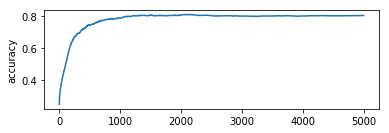

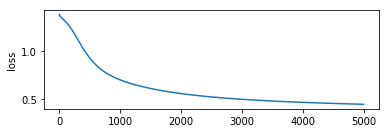

best_acc:  0.8100517368810052
Decision Boundary for hidden layer size 2, acc:  0.8033998521803399


In [25]:
# 梯度下降的参数（我直接手动赋值）
epsilon = 0.08 # 梯度下降的学习率
reg_lambda = 0.01 # 正则化的强度
epochs = 5000
dropout = False
level = 0.1

nn_architcture = [
    {'input_dim': nn_input_dim, 'output_dim': 16, 'actFunc': 'tanh'},
    {'input_dim': 16, 'output_dim': nn_output_dim, 'actFunc': 'tanh'},
]

layers, cost_history,accuracy_history  = train(X_train, Y_train, nn_architcture, epochs)
acc = get_acc(X_test, layers)
# plot_decision_boundary(lambda x: predict(x, layers))
# plt.title("Decision Boundary for hidden layer size 2.")
print("Decision Boundary for hidden layer size 2, acc: ", acc)

In [26]:
# nn_architcture = [
#     {'input_dim': nn_input_dim, 'output_dim': 16, 'actFunc': 'relu'},
# #     {'input_dim': 4, 'output_dim': 6, 'actFunc': 'tanh'},
# #     {'input_dim': 6, 'output_dim': 6, 'actFunc': 'tanh'},
# #     {'input_dim': 6, 'output_dim': 4, 'actFunc': 'tanh'},
#     {'input_dim': 16, 'output_dim': nn_output_dim, 'actFunc': 'relu'},
# ]

# layers, cost_history,accuracy_history  = train(X_train, Y_train, nn_architcture, epochs)
# acc = get_acc(X_test, layers)
# # plot_decision_boundary(lambda x: predict(x, layers))
# # plt.title("Decision Boundary for hidden layer size 2.")
# print("Decision Boundary for hidden layer size 2, acc: ", acc)

w: (512, 16)
b: (1, 16)
w: (16, 8)
b: (1, 8)
w: (8, 4)
b: (1, 4)
||epochs =>  0 ||cost =>  1.3862943611198908 ||acc =>  0.23577235772357724
||epochs =>  500 ||cost =>  1.3739622684327608 ||acc =>  0.29120473022912047
||epochs =>  1000 ||cost =>  1.3862943611198908 ||acc =>  0.23577235772357724
||epochs =>  1500 ||cost =>  1.3862943611198908 ||acc =>  0.23577235772357724
||epochs =>  2000 ||cost =>  1.3720073395375512 ||acc =>  0.5631929046563193
||epochs =>  2500 ||cost =>  1.3862943611198908 ||acc =>  0.23577235772357724
||epochs =>  3000 ||cost =>  1.3708238528322096 ||acc =>  0.23577235772357724
||epochs =>  3500 ||cost =>  1.3862943611198908 ||acc =>  0.7272727272727273
||epochs =>  4000 ||cost =>  1.3738591826025388 ||acc =>  0.29120473022912047
||epochs =>  4500 ||cost =>  1.3738550419807691 ||acc =>  0.23577235772357724


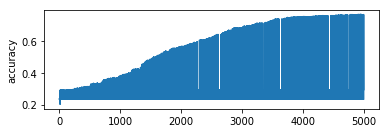

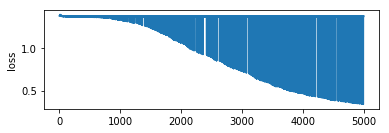

best_acc:  0.7657058388765706
Decision Boundary for hidden layer size 3. acc:  0.7649667405764967


In [27]:
# 梯度下降的参数
epsilon = 0.08 # 梯度下降的学习率
reg_lambda = 0.01 # 正则化的强度
epochs = 5000
dropout = True
level = 0.5

nn_architcture = [
    {'input_dim': nn_input_dim, 'output_dim': 16, 'actFunc': 'relu'},
    {'input_dim': 16, 'output_dim': 8, 'actFunc': 'relu'},
    {'input_dim': 8, 'output_dim': nn_output_dim, 'actFunc': 'relu'},
]

layers, cost_history,accuracy_history  = train(X_train, Y_train, nn_architcture, epochs)
acc = get_acc(X_test, layers)
# plot_decision_boundary(lambda x: predict(x, layers))
# plt.title("Decision Boundary for hidden layer size 3")
print("Decision Boundary for hidden layer size 3. acc: ", acc)

In [28]:
# nn_architcture = [
#     {'input_dim': nn_input_dim, 'output_dim': 16, 'actFunc': 'sigmoid'},
#     {'input_dim': 16, 'output_dim': 8, 'actFunc': 'sigmoid'},
#     {'input_dim': 8, 'output_dim': nn_output_dim, 'actFunc': 'sigmoid'},
# ]

# layers, cost_history,accuracy_history  = train(X_train, Y_train, nn_architcture, epochs)
# acc = get_acc(X_test, layers)
# # plot_decision_boundary(lambda x: predict(x, layers))
# # plt.title("Decision Boundary for hidden layer size 3")
# print("Decision Boundary for hidden layer size 3. acc: ", acc)

w: (512, 16)
b: (1, 16)
w: (16, 8)
b: (1, 8)
w: (8, 4)
b: (1, 4)
||epochs =>  0 ||cost =>  1.3860142898915064 ||acc =>  0.24981522542498152
||epochs =>  500 ||cost =>  0.7495005252529376 ||acc =>  0.7716186252771619
||epochs =>  1000 ||cost =>  0.552262899442362 ||acc =>  0.795269770879527
||epochs =>  1500 ||cost =>  0.4721311677918665 ||acc =>  0.8011825572801182
||epochs =>  2000 ||cost =>  0.4339556229211185 ||acc =>  0.8019216555801921
||epochs =>  2500 ||cost =>  0.41131147797736206 ||acc =>  0.7945306725794531


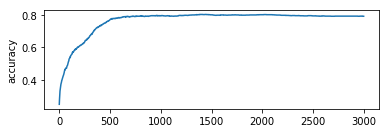

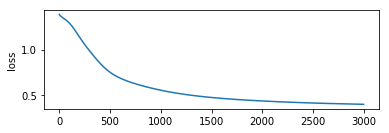

best_acc:  0.8033998521803399
Decision Boundary for hidden layer size 3. acc:  0.7923133776792314


In [29]:
# 梯度下降的参数
epsilon = 0.08 # 梯度下降的学习率
reg_lambda = 0.01 # 正则化的强度
epochs = 5000
dropout = False
level = 0.1


nn_architcture = [
    {'input_dim': nn_input_dim, 'output_dim': 16, 'actFunc': 'tanh'},
    {'input_dim': 16, 'output_dim': 8, 'actFunc': 'tanh'},
    {'input_dim': 8, 'output_dim': nn_output_dim, 'actFunc': 'tanh'},
]

layers, cost_history,accuracy_history  = train(X_train, Y_train, nn_architcture, epochs)
acc = get_acc(X_test, layers)
# plot_decision_boundary(lambda x: predict(x, layers))
# plt.title("Decision Boundary for hidden layer size 3")
print("Decision Boundary for hidden layer size 3. acc: ", acc)

w: (512, 16)
b: (1, 16)
w: (16, 16)
b: (1, 16)
w: (16, 8)
b: (1, 8)
w: (8, 4)
b: (1, 4)
||epochs =>  0 ||cost =>  1.388549721868972 ||acc =>  0.20620842572062084
||epochs =>  500 ||cost =>  0.7111493377668291 ||acc =>  0.7265336289726534
||epochs =>  1000 ||cost =>  0.559020816390632 ||acc =>  0.7413155949741316
||epochs =>  1500 ||cost =>  0.48375235143193007 ||acc =>  0.7819660014781966
||epochs =>  2000 ||cost =>  0.4209228576324621 ||acc =>  0.7849223946784922
||epochs =>  2500 ||cost =>  0.3925359451372513 ||acc =>  0.7900960827790096
||epochs =>  3000 ||cost =>  0.37759606801975054 ||acc =>  0.7930524759793053
||epochs =>  3500 ||cost =>  0.368293580884928 ||acc =>  0.7900960827790096
||epochs =>  4000 ||cost =>  0.36152125204068286 ||acc =>  0.7967479674796748
||epochs =>  4500 ||cost =>  0.35772538587606045 ||acc =>  0.7937915742793792


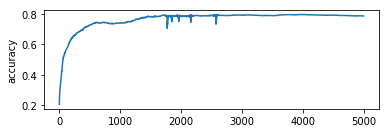

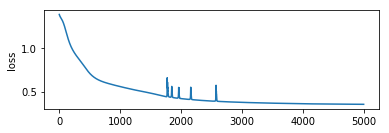

best_acc:  0.7974870657797487
Decision Boundary for hidden layer size 4. acc:  0.7871396895787139


In [30]:
# 梯度下降的参数（我直接手动赋值）
epsilon = 0.08 # 梯度下降的学习率
reg_lambda = 0.01 # 正则化的强度
epochs = 5000
dropout = False
level = 0.1


nn_architcture = [
    {'input_dim': nn_input_dim, 'output_dim': 16, 'actFunc': 'tanh'},
    {'input_dim': 16, 'output_dim': 16, 'actFunc': 'tanh'},
    {'input_dim': 16, 'output_dim': 8, 'actFunc': 'tanh'},
    {'input_dim': 8, 'output_dim': nn_output_dim, 'actFunc': 'tanh'},
]

layers, cost_history,accuracy_history  = train(X_train, Y_train, nn_architcture, epochs)
acc = get_acc(X_test, layers)
# plot_decision_boundary(lambda x: predict(x, layers))
# plt.title("Decision Boundary for hidden layer size 4")
print("Decision Boundary for hidden layer size 4. acc: ", acc)

w: (512, 16)
b: (1, 16)
w: (16, 10)
b: (1, 10)
w: (10, 8)
b: (1, 8)
w: (8, 4)
b: (1, 4)
||epochs =>  0 ||cost =>  1.385252724545861 ||acc =>  0.2609016999260902
||epochs =>  500 ||cost =>  1.0409172085135778 ||acc =>  0.23577235772357724
||epochs =>  1000 ||cost =>  1.3744399866666464 ||acc =>  0.7095343680709535
||epochs =>  1500 ||cost =>  1.3862943611198908 ||acc =>  0.28750923872875095
||epochs =>  2000 ||cost =>  0.25139942748611593 ||acc =>  0.7723577235772358
||epochs =>  2500 ||cost =>  1.370855191803331 ||acc =>  0.23577235772357724
||epochs =>  3000 ||cost =>  1.3708421757771039 ||acc =>  0.23577235772357724
||epochs =>  3500 ||cost =>  0.21007368799978426 ||acc =>  0.23577235772357724
||epochs =>  4000 ||cost =>  1.3862943611198908 ||acc =>  0.6784922394678492
||epochs =>  4500 ||cost =>  1.372029848483744 ||acc =>  0.7900960827790096


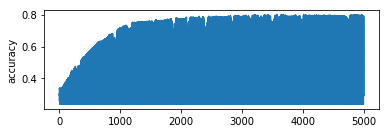

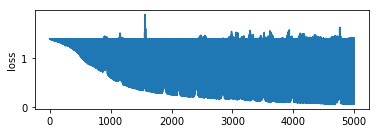

best_acc:  0.8019216555801921
Decision Boundary for hidden layer size 4. acc:  0.29120473022912047


In [31]:
# 梯度下降的参数
epsilon = 0.08 # 梯度下降的学习率
reg_lambda = 0.01 # 正则化的强度
epochs = 5000
dropout = True
level = 0.25


nn_architcture = [
    {'input_dim': nn_input_dim, 'output_dim': 16, 'actFunc': 'relu'},
    {'input_dim': 16, 'output_dim': 10, 'actFunc': 'relu'},
    {'input_dim': 10, 'output_dim': 8, 'actFunc': 'relu'},
    {'input_dim': 8, 'output_dim': nn_output_dim, 'actFunc': 'relu'},
]

layers, cost_history,accuracy_history  = train(X_train, Y_train, nn_architcture, epochs)
acc = get_acc(X_test, layers)
# plot_decision_boundary(lambda x: predict(x, layers))
# plt.title("Decision Boundary for hidden layer size 4")
print("Decision Boundary for hidden layer size 4. acc: ", acc)

w: (512, 16)
b: (1, 16)
w: (16, 32)
b: (1, 32)
w: (32, 16)
b: (1, 16)
w: (16, 8)
b: (1, 8)
w: (8, 4)
b: (1, 4)
||epochs =>  0 ||cost =>  1.3858308067976386 ||acc =>  0.2697708795269771
||epochs =>  500 ||cost =>  1.2689748880755949 ||acc =>  0.29120473022912047
||epochs =>  1000 ||cost =>  1.3728673398515256 ||acc =>  0.29120473022912047
||epochs =>  1500 ||cost =>  0.9130351023266297 ||acc =>  0.6496674057649667
||epochs =>  2000 ||cost =>  1.3711830108394842 ||acc =>  0.29120473022912047
||epochs =>  2500 ||cost =>  1.3862943611198908 ||acc =>  0.28750923872875095
||epochs =>  3000 ||cost =>  1.3862943611198908 ||acc =>  0.7265336289726534
||epochs =>  3500 ||cost =>  1.3711056688595673 ||acc =>  0.23577235772357724
||epochs =>  4000 ||cost =>  1.3708801625640261 ||acc =>  0.7124907612712491
||epochs =>  4500 ||cost =>  0.3725150823656728 ||acc =>  0.7257945306725795


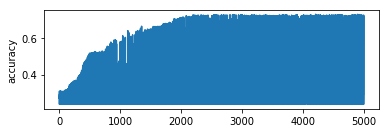

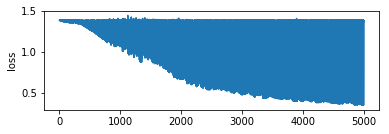

best_acc:  0.7309682187730968
Decision Boundary for hidden layer size 5. acc:  0.23577235772357724


In [32]:
# 梯度下降的参数（我直接手动赋值）
epsilon = 0.08 # 梯度下降的学习率
reg_lambda = 0.01 # 正则化的强度
epochs = 5000
dropout = True
level = 0.25


nn_architcture = [
    {'input_dim': nn_input_dim, 'output_dim': 16, 'actFunc': 'relu'},
    {'input_dim': 16, 'output_dim': 32, 'actFunc': 'relu'},
    {'input_dim': 32, 'output_dim': 16, 'actFunc': 'relu'},
    {'input_dim': 16, 'output_dim': 8, 'actFunc': 'relu'},
    {'input_dim': 8, 'output_dim': nn_output_dim, 'actFunc': 'relu'},
]

layers, cost_history,accuracy_history  = train(X_train, Y_train, nn_architcture, epochs)
acc = get_acc(X_test, layers)
print("Decision Boundary for hidden layer size 5. acc: ", acc)

w: (512, 20)
b: (1, 20)
w: (20, 15)
b: (1, 15)
w: (15, 10)
b: (1, 10)
w: (10, 8)
b: (1, 8)
w: (8, 4)
b: (1, 4)
||epochs =>  0 ||cost =>  1.386902357067561 ||acc =>  0.21286031042128603
||epochs =>  500 ||cost =>  0.9662173291656764 ||acc =>  0.5144124168514412
||epochs =>  1000 ||cost =>  0.5117928196878343 ||acc =>  0.6984478935698448
||epochs =>  1500 ||cost =>  0.38846008396757636 ||acc =>  0.720620842572062
||epochs =>  2000 ||cost =>  0.2887227286866918 ||acc =>  0.7309682187730968
||epochs =>  2500 ||cost =>  0.26933589711788986 ||acc =>  0.7280118255728012
||epochs =>  3000 ||cost =>  0.2664855731436825 ||acc =>  0.7302291204730229
||epochs =>  3500 ||cost =>  0.2664085899843483 ||acc =>  0.729490022172949
||epochs =>  4000 ||cost =>  0.26574486521342844 ||acc =>  0.7280118255728012
||epochs =>  4500 ||cost =>  0.2657227540968572 ||acc =>  0.7257945306725795


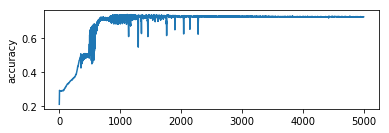

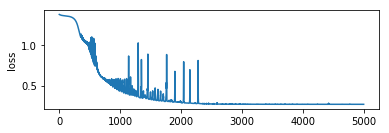

best_acc:  0.7413155949741316
Decision Boundary for hidden layer size 5. acc:  0.7272727272727273


In [33]:
# 梯度下降的参数（我直接手动赋值）
epsilon = 0.08 # 梯度下降的学习率
reg_lambda = 0.01 # 正则化的强度
epochs = 5000
dropout = False
level = 0.5


nn_architcture = [
    {'input_dim': nn_input_dim, 'output_dim': 20, 'actFunc': 'relu'},
    {'input_dim': 20, 'output_dim': 15, 'actFunc': 'relu'},
    {'input_dim': 15, 'output_dim': 10, 'actFunc': 'relu'},
    {'input_dim': 10, 'output_dim': 8, 'actFunc': 'relu'},
    {'input_dim': 8, 'output_dim': nn_output_dim, 'actFunc': 'relu'},
]

layers, cost_history,accuracy_history  = train(X_train, Y_train, nn_architcture, epochs)
acc = get_acc(X_test, layers)
# plot_decision_boundary(lambda x: predict(x, layers))
# plt.title("Decision Boundary for hidden layer size 4")
print("Decision Boundary for hidden layer size 5. acc: ", acc)

w: (512, 32)
b: (1, 32)
w: (32, 24)
b: (1, 24)
w: (24, 16)
b: (1, 16)
w: (16, 8)
b: (1, 8)
w: (8, 16)
b: (1, 16)
w: (16, 24)
b: (1, 24)
w: (24, 8)
b: (1, 8)
w: (8, 4)
b: (1, 4)
||epochs =>  0 ||cost =>  1.3862943611198908 ||acc =>  0.23577235772357724
||epochs =>  500 ||cost =>  1.3862943611198908 ||acc =>  0.28750923872875095
||epochs =>  1000 ||cost =>  1.373869812240426 ||acc =>  0.29120473022912047
||epochs =>  1500 ||cost =>  1.3738593806110113 ||acc =>  0.23577235772357724
||epochs =>  2000 ||cost =>  1.3738516107982879 ||acc =>  0.23577235772357724
||epochs =>  2500 ||cost =>  1.3862943611198908 ||acc =>  0.29120473022912047
||epochs =>  3000 ||cost =>  1.3738503801787585 ||acc =>  0.29120473022912047
||epochs =>  3500 ||cost =>  1.3862943611198908 ||acc =>  0.29120473022912047
||epochs =>  4000 ||cost =>  1.3862943611198908 ||acc =>  0.23577235772357724
||epochs =>  4500 ||cost =>  1.3738502824284478 ||acc =>  0.23577235772357724


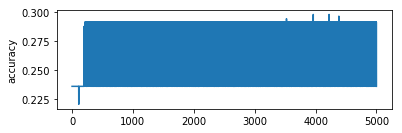

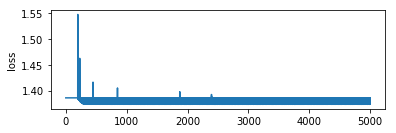

best_acc:  0.29785661492978566
Decision Boundary for hidden layer size 8. acc:  0.29120473022912047


In [34]:
# 梯度下降的参数（我直接手动赋值）
epsilon = 0.08 # 梯度下降的学习率
reg_lambda = 0.01 # 正则化的强度
epochs = 5000
dropout = True
level = 0.5


nn_architcture = [
    {'input_dim': nn_input_dim, 'output_dim': 32, 'actFunc': 'relu'},
    {'input_dim': 32, 'output_dim': 24, 'actFunc': 'relu'},
    {'input_dim': 24, 'output_dim': 16, 'actFunc': 'relu'},
    {'input_dim': 16, 'output_dim': 8, 'actFunc': 'relu'},
    {'input_dim': 8, 'output_dim': 16, 'actFunc': 'relu'},
    {'input_dim': 16, 'output_dim': 24, 'actFunc': 'relu'},
    {'input_dim': 24, 'output_dim': 8, 'actFunc': 'relu'},
    {'input_dim': 8, 'output_dim': nn_output_dim, 'actFunc': 'relu'},
]

layers, cost_history,accuracy_history  = train(X_train, Y_train, nn_architcture, epochs)
acc = get_acc(X_test, layers)
# plot_decision_boundary(lambda x: predict(x, layers))
# plt.title("Decision Boundary for hidden layer size 4")
print("Decision Boundary for hidden layer size 8. acc: ", acc)